**Airbnb Calendar -Time-Series Analysis**

# Introduction

## Read in libraries, data, and set notebook preferences

**Read in libraries**

In [81]:
#Read in libraries
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

**Read in Data**

In [82]:
#Set path to local machine for data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate/'

#Read in Airbnb Calendar data
calendar = pd.read_csv(path + '2020_0130_Calendar_Cleaned.csv', sep = ',',
                       parse_dates=['date'], low_memory=True,index_col=0)

#Read in Zillow data
zillow = pd.read_csv(path + '2020_0130_Zillow_Cleaned.csv', parse_dates=['Date'],
                     index_col=0, sep=',')

**Set notebook preferences**

In [83]:
#Set plot aesthetics for notebook
sns.set(style='whitegrid', palette='pastel', color_codes=True)

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_rows',100)

#Set float format
pd.options.display.float_format = '{:.0f}'.format

#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Preview Data

## Airbnb Calendar Data

In [84]:
#View shape and preview calendar data
print(calendar.shape)

(14125242, 5)


## Zillow Data

In [85]:
#View shape and preview calendar data
print(zillow.shape)
zillow.head()

(277104, 9)


,City,County,Metro,Zip,State,SizeRank,Bedrooms,Date,Median_Rent
4928,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-03-01,1200
11368,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-04-01,1250
17808,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-05-01,1200
24248,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-06-01,1250
30688,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-07-01,1225


# Time Series Analysis

## Date preparation, indexing and feature engineering

### Calendar data preparation

In [86]:
#Set date as index in calendar
calendar.set_index('date', inplace=True)

In [87]:
#Extract data from index and assign to columns 
calendar['year'] = calendar.index.year
calendar['month'] = calendar.index.month
calendar['day'] = calendar.index.day
calendar['weekday'] = calendar.index.weekday
calendar['month_year'] = calendar.index.to_period('M')

#Check
calendar.head()

,index,available,listing_id,price,year,month,day,weekday,month_year
date,,,,,,,,,
2019-04-05,0,True,21190709,5000,2019,4,5,4,2019-04
2019-04-04,1,True,21190709,5000,2019,4,4,3,2019-04
2019-04-03,2,True,21190709,5000,2019,4,3,2,2019-04
2019-04-02,3,True,21190709,5000,2019,4,2,1,2019-04
2019-04-01,4,True,21190709,5000,2019,4,1,0,2019-04


### Zillow data preparation

In [88]:
#Set date as index
zillow.set_index('Date', inplace=True)

zillow.head()

,City,County,Metro,Zip,State,SizeRank,Bedrooms,Median_Rent
Date,,,,,,,,
2010-03-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1200
2010-04-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1250
2010-05-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1200
2010-06-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1250
2010-07-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1225


## Airbnb Growth in SF(12/2018 - 12/2019)?

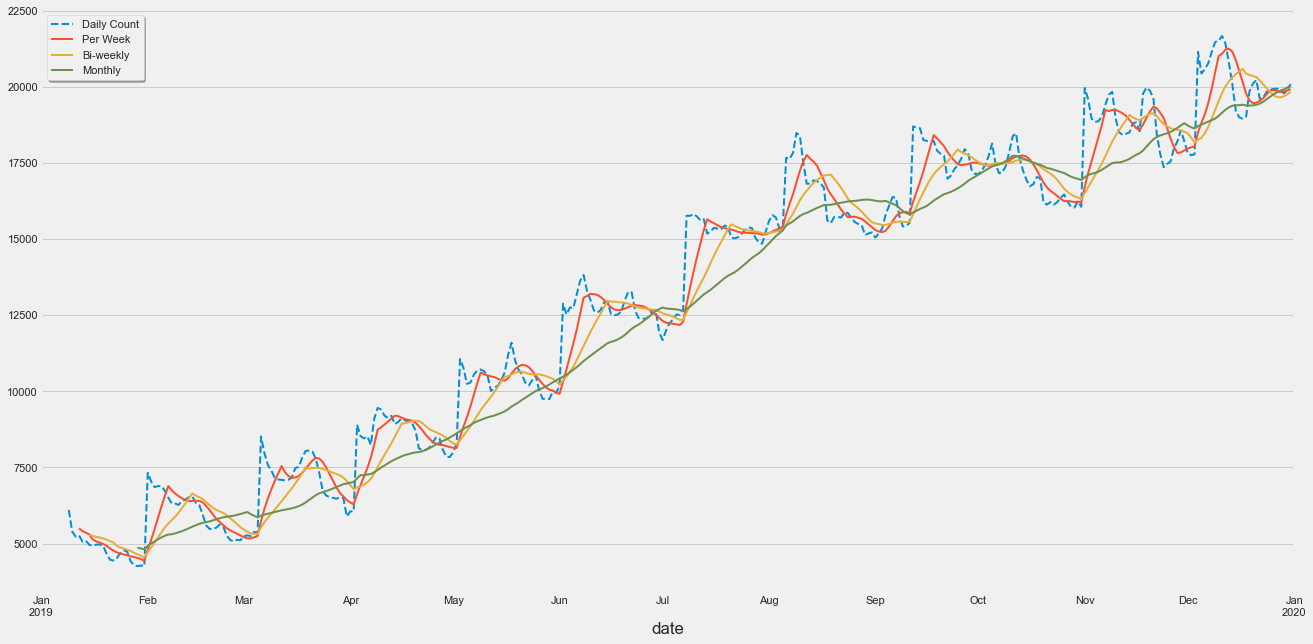

In [116]:
#Store count of booked evenings in Sf per night 
booked_nights = calendar[calendar['available'] == 0].groupby(['date'])['available'].count()

weekly_mean=booked_nights.rolling(window=7,min_periods=7).mean()

biweekly=booked_nights.rolling(window=14,min_periods=7).mean()
monthly=booked_nights.rolling(window=30,min_periods=21).mean()

#Set plot
fig, ax = plt.subplots(figsize=(20,10))

#Set 538 plot style
plt.style.use('fivethirtyeight')

#PLot count of booked nights per evening
booked_nights.plot(label = 'Daily Count',kind = 'line',style='--', linewidth=2,)



#Plot rolling average per week
rolling_mean.plot(label = 'Per Week',linewidth=2)
biweekly.plot(label = 'Bi-weekly',linewidth=2)
monthly.plot(label = 'Monthly',linewidth=2)

#Set plot aesthetics
ax.legend(fancybox = True, frameon=True, shadow = True)
ax.set_xlim(['2019', '2020'])
ax.grid(False, axis = 'x')

# Median rent across the United States

(504, 598)

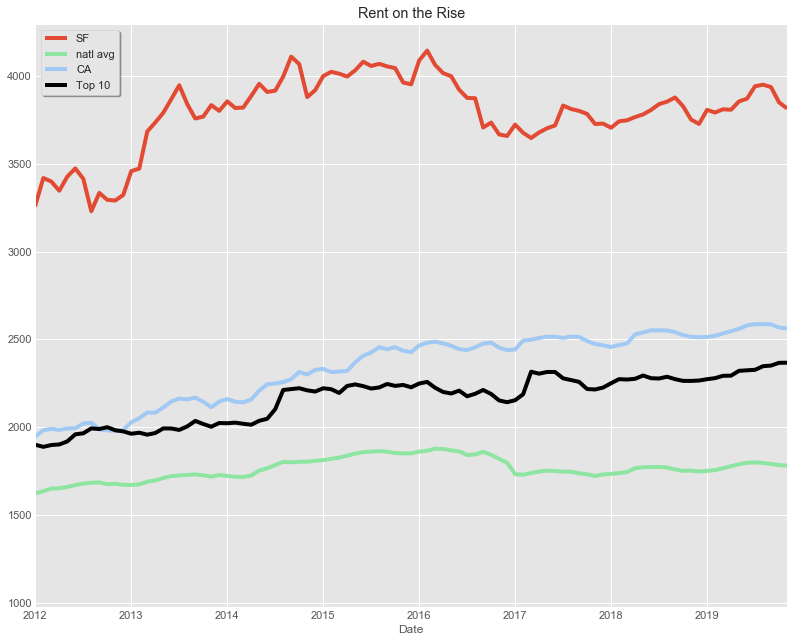

In [117]:
#SF vs rest of US Rent

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize = (12,10))
ax1 = zillow[zillow.City == 'San Francisco'].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line',
                                                                            label= 'SF', ax=ax)
ax2 = zillow.groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color= 'g', label = 'natl avg')#natl average

#We also noted each state's region size ranking, which represents how big it is population-wise;
#California is ranked No. 1 with the largest population of all states, while Wyoming is ranked No. 51
ax3 = zillow[zillow.State == 'CA'].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color = 'b', label= 'CA',
                                                                               )#this is compared to CA

ax4 = zillow.loc[(zillow.State != 'CA') & (zillow.SizeRank.isin(np.arange(1,15)))].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line', color = 'black',
                                                                         label = 'Top 10',
                                                                            )#purp(top 10 largest cities in US)


plt.title('Rent on the Rise')
ax.legend(fancybox = True, frameon=True, shadow = True)
ax.set_xlim(['2012', '2019-11-01'])   # set the xlim to left, right


Can Airbnb be an viable option for a 1-month stay in SF?

(576, 598)

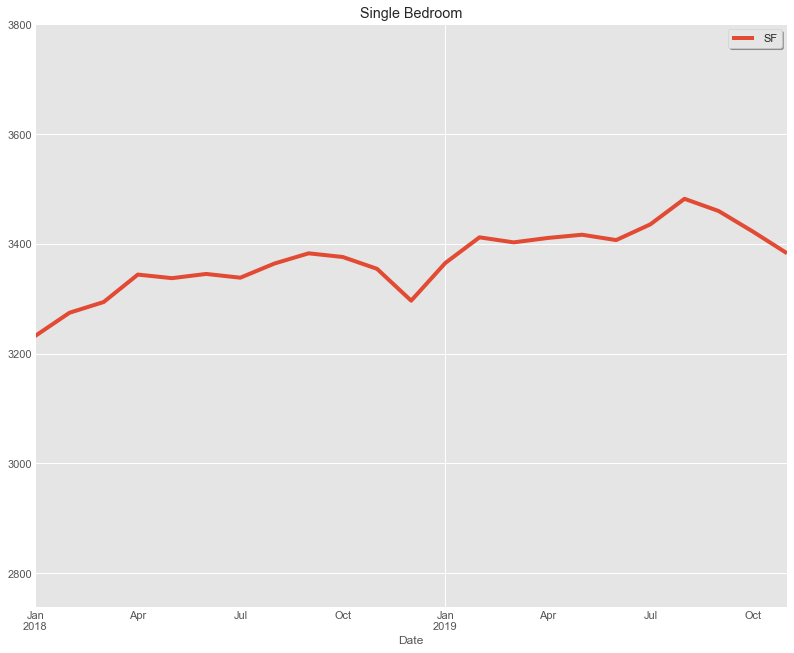

In [118]:
fig, ax = plt.subplots(figsize = (12,10))
ax1 = zillow.loc[(zillow.Bedrooms == 1) & (zillow.City == 'San Francisco')].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line',
                                                                            label= 'SF', ax=ax)


plt.title('Single Bedroom')
ax.legend(fancybox = True, frameon=True, shadow = True)
ax.set_xlim(['2018', '2019-11-01'])   # set the xlim to left, right

In [ ]:
calendar.head()

* Comparing monthly rent of airbnb to zillow

### Principal Component Analysis